# Step 1: Setup and Prepare the State to Teleport

**Task**  
1. Create three quantum registers (`q0` for the data qubit, `q1` for Alice’s qubit, `q2` for Bob’s qubit) and three classical registers (`c0` and `c1` to store Alice’s measurement outcomes, `c2` to store Bob’s final measurement).  
2. Prepare an arbitrary state  
$$
|\psi\rangle \;=\;\cos\Bigl(\tfrac{\theta}{2}\Bigr)\,|0\rangle \;+\;e^{i\phi}\,\sin\Bigl(\tfrac{\theta}{2}\Bigr)\,|1\rangle
$$  
on qubit `q0` with $\theta = \pi/3$, $\phi = \pi/6$.  
3. Draw the circuit to verify the state preparation.  

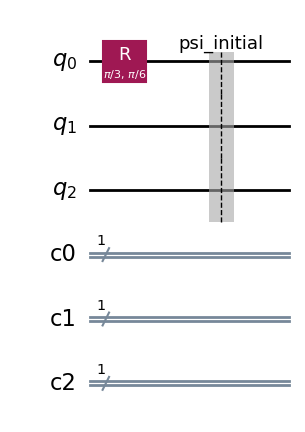

In [4]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Create quantum and classical registers
qreg = QuantumRegister(3, name='q')      # q[0]=data, q[1]=Alice, q[2]=Bob
creg0 = ClassicalRegister(1, name='c0')   # Alice’s measurement of q0
creg1 = ClassicalRegister(1, name='c1')   # Alice’s measurement of q1
creg2 = ClassicalRegister(1, name='c2')   # Bob’s final measurement of q2

# Build the circuit
qc = QuantumCircuit(qreg, creg0, creg1, creg2)

# Prepare the state |ψ> on q0
theta = np.pi / 3
phi = np.pi / 6
qc.r(theta, phi, qreg[0])        # Rotate q0 to |ψ>
qc.save_statevector(label='psi_initial')

# Display the circuit so far
qc.draw('mpl')

<details>
<summary><b>Solution Explanation</b></summary>

We first import the necessary Qiskit modules and NumPy. We create:

- A 3-qubit register (`qreg`) where:  
  - `q[0]` will hold the state $|\psi\rangle$,  
  - `q[1]` will be Alice’s half of the Bell pair,  
  - `q[2]` will be Bob’s half of the Bell pair.  

- Three classical single-bit registers:  
  - `c0` to record the measurement of `q0` (Alice’s first Bell‐measurement outcome),  
  - `c1` to record the measurement of `q1` (Alice’s second Bell‐measurement outcome),  
  - `c2` to record Bob’s final measurement of `q2`.  

We then apply an $R(\theta,\phi)$ rotation to qubit `q0` to prepare  
$$
|\psi\rangle = \cos\Bigl(\tfrac{\theta}{2}\Bigr)\,|0\rangle \;+\; e^{\,i\phi}\,\sin\Bigl(\tfrac{\theta}{2}\Bigr)\,|1\rangle,
$$  
with $\theta = \pi/3$, $\phi = \pi/6$. Finally, we save the statevector labeled `"psi_initial"` so that later we can compare Bob’s qubit with this original state.  
</details>

# Step 2: Creating the Bell Pair (Alice ↔ Bob)

**Task**  
1. Create a maximally entangled Bell pair between `q1` (Alice’s half) and `q2` (Bob’s half).  
2. Draw the circuit to show the Bell‐pair preparation.  

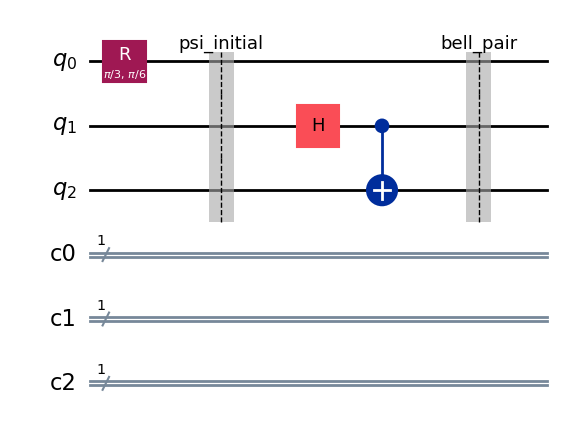

In [5]:
# Step 2: Apply H on q1, then CNOT from q1 → q2
qc.h(qreg[1])
qc.cx(qreg[1], qreg[2])
qc.save_statevector(label='bell_pair')

# Display the circuit including the previously prepared state
qc.draw('mpl')

<details>
<summary><b>Solution Explanation</b></summary>

- We apply a Hadamard gate on qubit `q1`, creating $\tfrac{|0\rangle + |1\rangle}{\sqrt{2}}$.  
- We then apply a CNOT controlled by `q1` targeting `q2`, which yields the Bell state  
  $$
  |\Phi^+\rangle_{1,2} \;=\; \tfrac{1}{\sqrt{2}}\bigl(|00\rangle + |11\rangle\bigr)_{1,2}.
  $$  
- We call `.save_statevector(label='bell_pair')` so that we can inspect this entangled pair if desired.  

At this point, the circuit has:  
1. Prepared $|\psi\rangle$ on `q0`,  
2. Created $|\Phi^+\rangle$ on (`q1`, `q2`).  

Drawing `qc.draw('mpl')` shows all gates so far.  
</details>

# Step 3: Alice Performs a Bell-State Measurement on (q0, q1)

**Task**  
1. Entangle the data qubit `q0` with Alice’s half of the Bell pair `q1`.  
2. Measure `q0` into classical bit `c0` and `q1` into classical bit `c1`.  
3. Draw the updated circuit.  

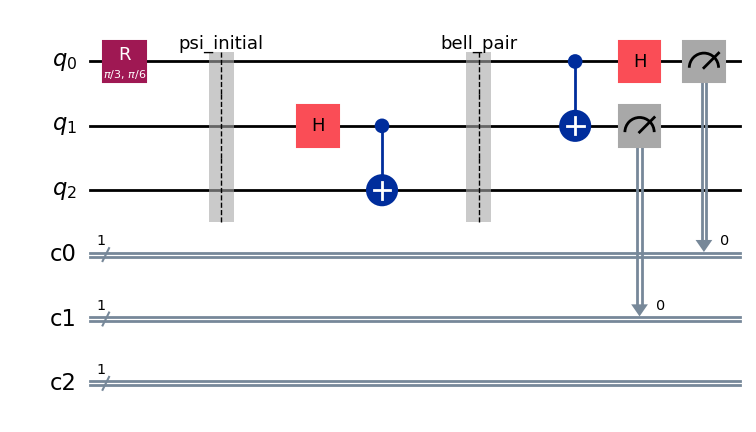

In [6]:
# Step 3: Bell‐measurement by Alice
qc.cx(qreg[0],qreg[1])           
qc.h(qreg[0]) 

# Measure Alice’s qubits:
qc.measure(qreg[0], creg0[0])    # q0 → c0
qc.measure(qreg[1], creg1[0])    # q1 → c1

# Display the circuit including all previous gates
qc.draw('mpl')

<details>
<summary><b>Solution Explanation</b></summary>

- The CNOT from `q0` to `q1` and the subsequent Hadamard on `q0` implement a Bell‐state measurement on the two qubits `(q0, q1)`.  
- Measuring `q0` and `q1` in the computational basis now projects them onto one of the four Bell outcomes. The classical bits (`c0`, `c1`) store those two measurement results (00, 01, 10, or 11).  

After these operations, Alice has completely “collapsed” her qubits and obtained two classical bits. This is the key step in teleportation: Alice’s measurement entangles her qubits and relays the information to Bob.  
</details>


# Step 4: Bob Applies Conditional Corrections on q2

**Task**  
1. Based on Alice’s two classical bits (`c0`, `c1`), apply correction gates on Bob’s qubit `q2`:  
   - If `c1 == 1`, apply ? on `q2`.  
   - If `c0 == 1`, apply ? on `q2`.  
2. Draw the updated circuit showing the two classically‐controlled gates.  

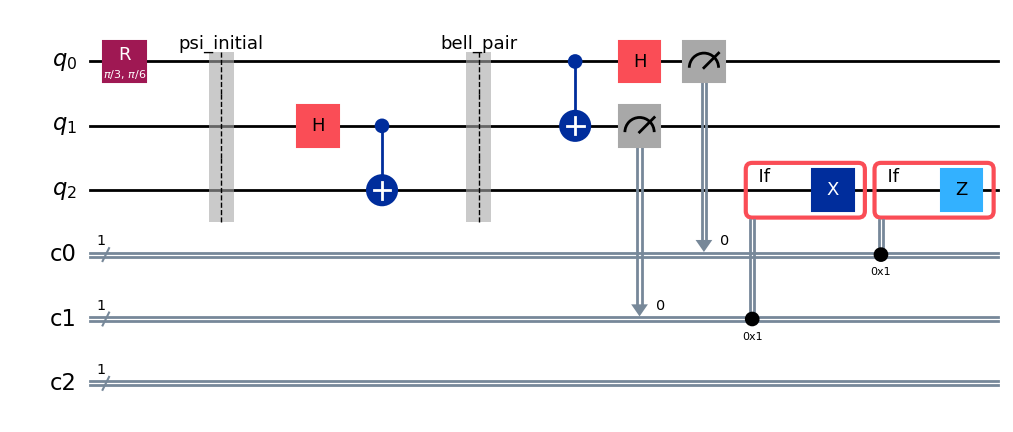

In [8]:
# Use structured if_test blocks to apply corrections
with qc.if_test((creg1, 1)):
    qc.x(qreg[2]) # <---

with qc.if_test((creg0, 1)):
    qc.z(qreg[2]) # <---

# Draw the full circuit including all previous steps
qc.draw('mpl')

<details>
<summary><b>Solution Explanation</b></summary>

- We could have used `qc.x(qreg[2]).c_if(creg1, 1)` and `qc.z(qreg[2]).c_if(creg0, 1)` directly (commented out above), but in this notebook we follow the structured `if_test` pattern.  
- The block `with qc.if_test((creg1, 1)):` means “execute the indented gates only if the classical register `creg1` equals 1.” Inside that block, we call `qc.x(qreg[2])`, so Bob applies an $X$ on his qubit whenever Alice’s second bit (`c1`) is 1.  
- Similarly, `with qc.if_test((creg0, 1)):` wraps `qc.z(qreg[2])` so that a $Z$ is applied on Bob’s qubit only if Alice’s first bit (`c0`) is 1.  
- After these two conditional blocks, Bob’s qubit `q2` will be in the original state $|\psi\rangle$ (up to a global phase). Drawing `qc.draw('mpl')` now shows the two classical‐controlled operations.  
</details>

# Step 5: Verify Teleportation

**Task**  
1. Measure Bob’s qubit `q2` into classical bit `c2`.  
2. Run a shots-based simulation (e.g., 1024 shots) and collect the counts for `c2`.  
3. Compare the observed frequencies with the theoretical probabilities  
$$
P(0) = \cos^2\!\Bigl(\tfrac{\theta}{2}\Bigr), 
\quad
P(1) = \sin^2\!\Bigl(\tfrac{\theta}{2}\Bigr).
$$  
4. Plot a histogram of the observed counts for `q2`.  

Observed counts for q2 (Bob) after 1024 shots: {'0': 765, '1': 259}
Theoretical probabilities: 0 → 0.750, 1 → 0.250


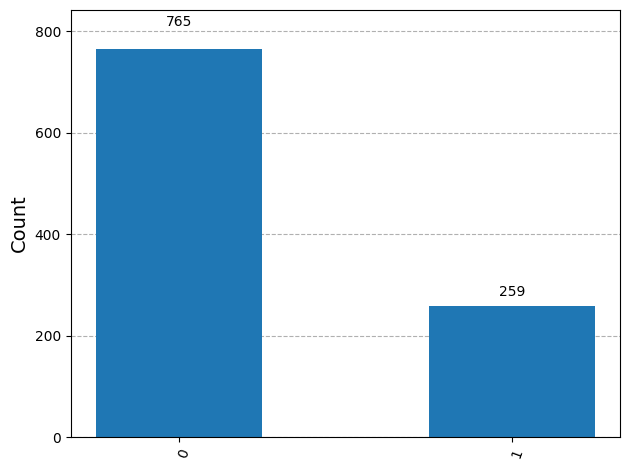

In [9]:
# Step 5: Measure Bob’s qubit and run a shots-based simulation

# 1) Add the final measurement for q2 
qc.measure(qreg[2], creg2[0])
qc.draw('mpl')

# 2) Run with AerSimulator for 1024 shots
from qiskit import transpile
from qiskit_aer import AerSimulator

simulator = AerSimulator()
compiled = transpile(qc, simulator)
job = simulator.run(compiled, shots=1024)
result = job.result()
counts_all = result.get_counts()

# 3) Extract only Bob’s bit (c2) from each three-bit key "c2 c1 c0"
counts_q2 = {'0': 0, '1': 0}
for bitstr, ct in counts_all.items():
    # bitstr is in order 'c2 c1 c0', e.g. '010'
    bob_bit = bitstr[0]
    counts_q2[bob_bit] += ct

print("Observed counts for q2 (Bob) after 1024 shots:", counts_q2)

# 4) Compute theoretical probabilities given theta = π/3
p0 = np.cos(theta / 2) ** 2
p1 = np.sin(theta / 2) ** 2
print(f"Theoretical probabilities: 0 → {p0:.3f}, 1 → {p1:.3f}")

# 5) Plot the histogram
plot_histogram(counts_q2)

<details>
<summary><b>Solution Explanation</b></summary>

1. We append `qc.measure(qreg[2], creg2[0])` so that Bob’s qubit `q2` is measured into classical register `c2`.  
2. We use a single `AerSimulator()` (default method “automatic”) and run the full circuit with 1024 shots.  
3. The raw counts from `result.get_counts()` are keyed by the full three-bit string (`c2c1c0`); we extract the leftmost bit to build `counts_q2`.  
4. The theoretical probabilities are  
   $$
   P(0) \;=\; \cos^2\!\Bigl(\tfrac{\theta}{2}\Bigr), \quad
   P(1) \;=\; \sin^2\!\Bigl(\tfrac{\theta}{2}\Bigr),
   $$  
   with $\theta = \pi/3$.  
5. Finally, we plot the histogram of `counts_q2` and verify that the observed frequencies for 0 and 1 on Bob’s qubit match (within shot noise) the theoretical values.  
</details>
